In [48]:
from cv2 import aruco
import cv2
import numpy as np
import matplotlib.pyplot as plt
import msgpack as mp
import msgpack_numpy as mpn
import os

from tqdm import tqdm
import csv
import pandas as pd
import polars as pl
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
from support.pd_support import *

from datetime import datetime

from support.pd_support import *
from support.ar_calculations import *

from scipy.signal import savgol_filter
from scipy import integrate

In [49]:
_pth = os.getcwd()
_pth = os.path.dirname(_pth)
_parent_folder = "cam_june_22_2023"
_calib_folder_name = "calibration_00"

_folder_name = "sk40_30_4_rotation_imu_16"
# _folder_name = "board"

_base_pth = os.path.join(_pth,"recorded_data",_parent_folder)

_webcam_calib_folder = os.path.join(_pth,"recorded_data",_parent_folder,_calib_folder_name)
_webcam_calib_folder = os.path.join(_webcam_calib_folder)
_webcam_calib_pth = os.path.join( _webcam_calib_folder, "webcam_calibration.msgpack")

with open(_webcam_calib_pth, "rb") as f:
    webcam_calib = mp.Unpacker(f, object_hook=mpn.decode)
    _temp = next(webcam_calib)
    _webcam_cam_mat = _temp[0]
    _webcam_dist = _temp[1]

ar_lframe_pth = os.path.join(_webcam_calib_folder, "webcam_rotmat_7.msgpack")
with open(ar_lframe_pth, "rb") as f:
    ar_lframe = mp.Unpacker(f, object_hook=mpn.decode)
    _ar_lframe_rot = next(ar_lframe)
    _ar_lframe_org = next(ar_lframe)


IMU

In [50]:
_imu_pth = os.path.join(_base_pth, _folder_name, "imu01.csv")
_imu_df = pl.read_csv(_imu_pth)

dt = _imu_df["mils"].diff().mean()/1000
dt = 0.01
filter_size = 101
filter_order = 9
_mean_gx = _imu_df["gx"][:filter_size ].mean()
_mean_gy = _imu_df["gy"][:filter_size ].mean()
_mean_gz = _imu_df["gz"][:filter_size ].mean()
_mean_ax = _imu_df["ax"][:filter_size ].mean()
_mean_ay = _imu_df["ay"][:filter_size ].mean()
_mean_az = _imu_df["az"][:filter_size ].mean()

# subtracting mean from gyro
_imu_df = _imu_df.with_columns([
    (pl.col("gx") - _mean_gx).alias("gx"),
    (pl.col("gy") - _mean_gy).alias("gy"),
    (pl.col("gz") - _mean_gz).alias("gz"),
])

# subtracting mean from accel
_imu_df = _imu_df.with_columns([
    (pl.col("ax") - _mean_ax).alias("ax"),
    (pl.col("ay") - _mean_ay).alias("ay"),
    (pl.col("az") - _mean_az).alias("az"),
])

# apply savgol filter
_imu_df = _imu_df.with_columns([
                        pl.col("ax").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                        pl.col("ay").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                        pl.col("az").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode()
                    ])


_imu_df = _imu_df.with_columns([
                (pl.col("gx").cumsum()*dt * 9.81).alias("ang_x"),
                (pl.col("gy").cumsum()*dt * 9.81).alias("ang_y"),
                (pl.col("gz").cumsum()*dt * 9.81).alias("ang_z"),
            ])

_imu_df = _imu_df.with_columns(pl.col("sys_time").str.to_datetime().alias("time"))

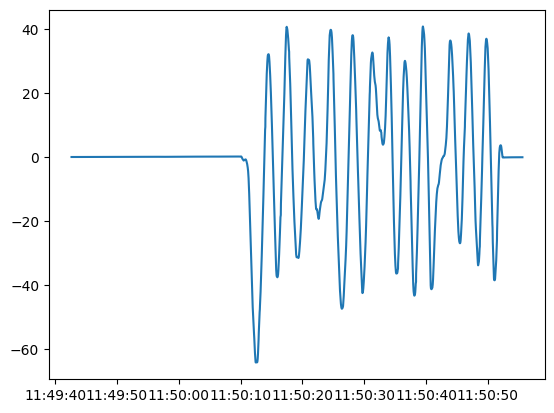

In [51]:
plt.plot(_imu_df["time"],_imu_df["ang_z"].to_numpy())

In [52]:
ARUCO_PARAMETERS = aruco.DetectorParameters()
ARUCO_DICT = aruco.getPredefinedDictionary(aruco.DICT_ARUCO_ORIGINAL)
detector = aruco.ArucoDetector(ARUCO_DICT, ARUCO_PARAMETERS)
markerLength = 0.04
markerSeperation = 0.01

board = aruco.GridBoard(
        size= [1,1],
        markerLength=markerLength,
        markerSeparation=markerSeperation,
        dictionary=ARUCO_DICT)

In [53]:
# timestamp
ts = []
ts_pth = os.path.join(_base_pth, _folder_name, "webcam_timestamp.msgpack")
ts_file = open(ts_pth, "rb")
ts_unpacker = mp.Unpacker(ts_file, object_hook=mpn.decode)
for ts_data in ts_unpacker:
    ts.append(ts_data)

In [54]:
_video_pth = os.path.join(_base_pth,_folder_name,"webcam_color.msgpack")

_mocap_pth = os.path.join(os.path.dirname(os.path.dirname(_video_pth)), "sk40", f"{_folder_name}.csv")
_mocap_df, st_time = read_rigid_body_csv(_mocap_pth)
_mocap_df = add_datetime_col(_mocap_df, st_time, "seconds")

In [55]:
_om = get_rb_marker_name(1)
_xm = get_rb_marker_name(3)
_zm = get_rb_marker_name(4)

In [56]:
"""
checking position
defining initial frame of reference
"""

xvec = [_mocap_df[_xm["x"]].iloc[0], _mocap_df[_xm["y"]].iloc[0], _mocap_df[_xm["z"]].iloc[0]]
xvec = np.array(xvec).reshape(3,1)

zvec = [_mocap_df[_zm["x"]].iloc[0], _mocap_df[_zm["y"]].iloc[0], _mocap_df[_zm["z"]].iloc[0]]
zvec = np.array(zvec).reshape(3,1)

org = [_mocap_df[_om["x"]].iloc[0], _mocap_df[_om["y"]].iloc[0], _mocap_df[_om["z"]].iloc[0]]
org = np.array(org).reshape(3,1)

v1 = xvec - org  # v1
v2 = zvec - org  # v2

vxnorm = v1 / np.linalg.norm(v1)

vzcap = v2 - (vxnorm.T @ v2) * vxnorm
vznorm = vzcap / np.linalg.norm(vzcap)

vynorm = np.cross(vznorm.T[0], vxnorm.T[0]).reshape(3, 1)
rotMat = np.hstack((vxnorm, vynorm, vznorm)) # rotation matrix

In [57]:
# @njit
def apply_rot_mat(mc_val, rotMat, org):
    return (rotMat.T @ (mc_val - org)).T[0]

In [58]:
# This cell is optimized to run faster using polars
_mc_df = _mocap_df[["time", _om["x"], _om["y"], _om["z"]]].copy()
_mc_df = _mc_df.rename(columns={_om["x"]: "x", _om["y"]: "y", _om["z"]: "z"})
# _mc_df = _mc_df.astype({"x": np.float64, "y": np.float64, "z": np.float64})

_mc_pl_df = pl.from_pandas(_mc_df)

my_dict = {"x":[],"y":[],"z":[]}

for i in tqdm(range(len(_mc_df))):
    _x, _y, _z = apply_rot_mat(_mc_pl_df[i, 1:].to_numpy().T, rotMat, org)
    my_dict["x"].append(_x)
    my_dict["y"].append(_y)
    my_dict["z"].append(_z)	

_mc_df["x"] = my_dict["x"]
_mc_df["y"] = my_dict["y"]
_mc_df["z"] = my_dict["z"]

100%|██████████| 5775/5775 [00:00<00:00, 9374.37it/s]


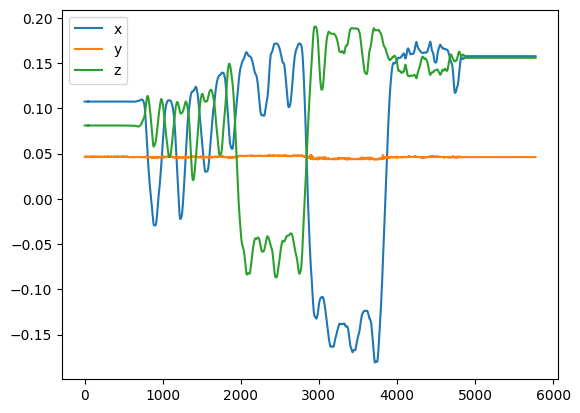

In [59]:
plt.plot(_mocap_df[_om["x"]], label="x")
plt.plot(_mocap_df[_om["y"]], label="y")
plt.plot(_mocap_df[_om["z"]], label="z")
plt.legend()

In [60]:
from ultralytics import YOLO

In [61]:
_model_name = "multi_160e_lp.pt"
_model_pth = os.path.join(os.getcwd(), "..", "models_save", _model_name)
model = YOLO(_model_pth)

In [62]:
            
def my_estimatePoseSingleMarkers(corners, marker_size, mtx, distortion):

    marker_points = np.array([[-marker_size / 2, marker_size / 2, 0],
                              [marker_size / 2, marker_size / 2, 0],
                              [marker_size / 2, -marker_size / 2, 0],
                              [-marker_size / 2, -marker_size / 2, 0]], dtype=np.float32)
    trash = []
    rvecs = []
    tvecs = []
    for c in corners:
        nada, R, t = cv2.solvePnP(marker_points, c, mtx, distortion, True, flags= cv2.SOLVEPNP_ITERATIVE)
        
        if not (R is None or t is None):
            R = np.array(R).reshape(1, 3).tolist()
            t = np.array(t).reshape(1, 3).tolist()
        
        rvecs.append(R)
        tvecs.append(t)
    return rvecs, tvecs

In [63]:
_video_pth = os.path.join(_base_pth,_folder_name,"webcam_color.msgpack")
_video_file = open(_video_pth, "rb")
_video_data = mp.Unpacker(_video_file, object_hook=mpn.decode)

default_ids = [0, 49, 80]

data_ml = {"frame_id":[],"marker_ids":[], "corners":[], "tvec":[], "rvec":[]}

counter = 0
val = None

ids = None
modelcorners = None
translation_vectors = None
rotation_vectors = None

for _frame in tqdm(_video_data):

    shape = _frame.shape
    result = model(_frame, verbose=False)[0]  
    modelcorners = []
    for _keys in result.keypoints.data:
        # print(_keys)
        modelcorners.append(_keys[0:4].cpu().numpy())
    modelcorners = np.array(modelcorners)

    if len(result.boxes.cls.cpu().numpy()) != 0: # if there are any detections else None
        _idx = result.boxes.cls.cpu().numpy()
        ids = []
        for i in _idx:
            match i:
                case 0:
                    ids.append([0])
                case 1:
                    ids.append([49])
                case 2:
                    ids.append([80])
        ids = np.array(ids, dtype=np.int32)
    else:
        ids = None

    if len(modelcorners) != 0: # if there are any detections else skip

        try:
            rvec, tvec= my_estimatePoseSingleMarkers(corners=modelcorners, marker_size=markerLength, mtx=_webcam_cam_mat, distortion=_webcam_dist)
            rotation_vectors = rvec
            translation_vectors = tvec
        except:
            ids = None

    if ids is None:
        data_ml["frame_id"].append(counter)
        data_ml["marker_ids"].append(None)
        data_ml["corners"].append(None)
        data_ml["tvec"].append(None)
        data_ml["rvec"].append(None)

    else:
        data_ml["frame_id"].append(counter)
        data_ml["marker_ids"].append(ids)
        data_ml["corners"].append(modelcorners)
        data_ml["tvec"].append(translation_vectors)
        data_ml["rvec"].append(rotation_vectors)

    counter+=1
    # break

_video_file.close()

722it [00:09, 75.43it/s]


In [64]:
coordinate_ml = {"0":{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]},
              "49":{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]},
              "80":{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]}}

doesnt_exist = [] # list of ids that doesnt exist in a frame
default_ids = [0, 49, 80]

for i in range(len(data_ml["frame_id"])):
    if data_ml["marker_ids"][i] is not None:

        if default_ids[0] not in data_ml["marker_ids"][i]:
            doesnt_exist.append(default_ids[0])
        if default_ids[1] not in data_ml["marker_ids"][i]:
            doesnt_exist.append(default_ids[1])
        if default_ids[2] not in data_ml["marker_ids"][i]:
            doesnt_exist.append(default_ids[2])

        for j in range(len(data_ml["marker_ids"][i])):
            if data_ml["marker_ids"][i][j] in default_ids:
                coordinate_ml[str(data_ml["marker_ids"][i][j][0])]["x"].append( data_ml["tvec"][i][j][0][0])
                coordinate_ml[str(data_ml["marker_ids"][i][j][0])]["y"].append( data_ml["tvec"][i][j][0][1])
                coordinate_ml[str(data_ml["marker_ids"][i][j][0])]["z"].append( data_ml["tvec"][i][j][0][2])
                coordinate_ml[str(data_ml["marker_ids"][i][j][0])]["rx"].append(data_ml["rvec"][i][j][0][0])
                coordinate_ml[str(data_ml["marker_ids"][i][j][0])]["ry"].append(data_ml["rvec"][i][j][0][1])
                coordinate_ml[str(data_ml["marker_ids"][i][j][0])]["rz"].append(data_ml["rvec"][i][j][0][2])
        for k in doesnt_exist:
            coordinate_ml[str(k)]["x"].append(np.nan)
            coordinate_ml[str(k)]["y"].append(np.nan)
            coordinate_ml[str(k)]["z"].append(np.nan)
            coordinate_ml[str(k)]["rx"].append(np.nan)
            coordinate_ml[str(k)]["ry"].append(np.nan)
            coordinate_ml[str(k)]["rz"].append(np.nan)
        doesnt_exist = []
    else:
        for k in default_ids:
            coordinate_ml[str(k)]["x"].append(np.nan)
            coordinate_ml[str(k)]["y"].append(np.nan)
            coordinate_ml[str(k)]["z"].append(np.nan)
            coordinate_ml[str(k)]["rx"].append(np.nan)
            coordinate_ml[str(k)]["ry"].append(np.nan)
            coordinate_ml[str(k)]["rz"].append(np.nan)

In [65]:
filter_size = 11
filter_order = 3

filter_0_df = pl.DataFrame(coordinate_ml["0"])
filter_49_df = pl.DataFrame(coordinate_ml["49"])
filter_80_df = pl.DataFrame(coordinate_ml["80"])

# apply savgol filter for columns rx, ry, rz

filter_0_df = filter_0_df.with_columns([
                                pl.col("rx").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                                pl.col("ry").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                                pl.col("rz").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode()
                            ])

filter_49_df = filter_49_df.with_columns([
                                pl.col("rx").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                                pl.col("ry").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                                pl.col("rz").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode()
                                ])

filter_80_df = filter_80_df.with_columns([
                                pl.col("rx").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                                pl.col("ry").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                                pl.col("rz").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode()
                                ])

In [66]:
rmat = []
for i in range(len(coordinate_ml["0"]["x"])):
    rotation_vectors_0 = np.array([coordinate_ml["0"]["rx"][i], coordinate_ml["0"]["ry"][i], coordinate_ml["0"]["rz"][i]])
    rotation_matrix_0 = cv2.Rodrigues(rotation_vectors_0)[0]
    rmat.append(rotation_matrix_0)

rmat_49 = []
for i in range(len(coordinate_ml["49"]["x"])):
    rotation_vectors_49 = np.array([coordinate_ml["49"]["rx"][i], coordinate_ml["49"]["ry"][i], coordinate_ml["49"]["rz"][i]])
    rotation_matrix_49 = cv2.Rodrigues(rotation_vectors_49)[0]
    rmat_49.append(rotation_matrix_49)

rmat_80 = []
for i in range(len(coordinate_ml["80"]["x"])):
    rotation_vectors_80 = np.array([coordinate_ml["80"]["rx"][i], coordinate_ml["80"]["ry"][i], coordinate_ml["80"]["rz"][i]])
    rotation_matrix_80 = cv2.Rodrigues(rotation_vectors_80)[0]
    rmat_80.append(rotation_matrix_80)

Orthonormalizing rmat

In [67]:
# orthonormalizing rmat
orthormat = np.linalg.qr(rmat)[0]

In [68]:
print(len(coordinate_ml["0"]["x"]), len(coordinate_ml["49"]["y"]), len(coordinate_ml["80"]["z"]), len(data_ml["frame_id"]))

722 722 722 722


In [69]:
df_0_ml = pl.DataFrame(coordinate_ml["0"])
df_49_ml = pl.DataFrame(coordinate_ml["49"])
df_80_ml = pl.DataFrame(coordinate_ml["80"])

In [70]:
translation_correction = np.array([0.045, -0.05, 0.045]).reshape(3, 1)

In [71]:
if type(df_0_ml) is not pl.DataFrame:
    df_0_ml = pl.from_pandas(df_0_ml)

tcoor_0_ml = {"x":[], "y":[], "z":[]}
for i in range(len(coordinate_ml["49"]["x"])):
    val = (_ar_lframe_rot.T @ (df_0_ml[["x", "y", "z"]][i].to_numpy().reshape(3,1) - _ar_lframe_org)) - translation_correction
    # val = (orthormat[0].T @ (df_0_ml[["x", "y", "z"]][i].to_numpy().reshape(3,1) - df_0_ml[['x', 'y', 'z']][0].to_numpy().reshape(3,1))) 

    if val is None:
        x = np.nan
        y = np.nan
        z = np.nan
    else:
        x = val[0][0]
        y = val[1][0]
        z = val[2][0]
    tcoor_0_ml["x"].append(x)
    tcoor_0_ml["y"].append(y)
    tcoor_0_ml["z"].append(z)


Bringing to skateboard frame

In [72]:
# This cell is optimized to run faster using polars

# calculate rotation matrix from xvec, zvec, org
_m_df = _mocap_df.copy()
_m_df = pl.from_pandas(_m_df)

_rotmat_i = []
for i in tqdm(range(len(_m_df))):
    
    _x_vec = _m_df[[_xm["x"], _xm["y"], _xm["z"]]][i, :].to_numpy().T
    _org = _m_df[[_om["x"], _om["y"], _om["z"]]][i, :].to_numpy().T
    _z_vec = _m_df[[_zm["x"], _zm["y"], _zm["z"]]][i, :].to_numpy().T

    _rotmat_i.append(calculate_rotmat(_x_vec, _z_vec, _org))
# calculating del rotmat for mc
_del_r = []
for i in tqdm(range(len(_rotmat_i))):
    _del_r.append(_rotmat_i[i].T@_rotmat_i[0])

# calculating angle for mc
_theta_x = []
_theta_y = []
_theta_z = []

for i in tqdm(_del_r):
    _theta_x.append(np.arctan2(i[2,1], i[2,2]))
    _theta_y.append(np.arctan2(-i[2,0], np.sqrt(i[2,1]**2 + i[2,2]**2)))
    _theta_z.append(np.arctan2(i[1,0], i[0,0]))
    
_theta_x = np.array(_theta_x)
_theta_y = np.array(_theta_y)
_theta_z = np.array(_theta_z)

# converting them to degrees
_theta_x = np.rad2deg(_theta_x)
_theta_y = np.rad2deg(_theta_y)
_theta_z = np.rad2deg(_theta_z)

100%|██████████| 5775/5775 [00:00<00:00, 345078.65it/s]


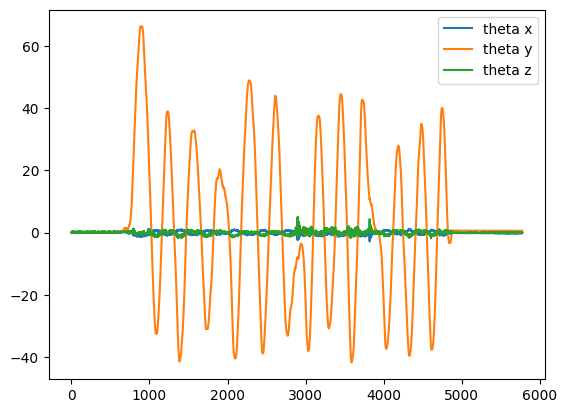

In [73]:
plt.plot(_theta_x, label="theta x")
plt.plot(_theta_y, label="theta y")
plt.plot(_theta_z, label="theta z")
plt.legend()

In [74]:
_del_r_0 = []
for i in tqdm(range(len(rmat))):
    _del_r_0.append(rmat[i].T@rmat[0])

# calculating angle for mc
_theta_x_0 = []
_theta_y_0 = []
_theta_z_0 = []

for i in tqdm(_del_r_0):
    _theta_x_0.append(np.arctan2(i[2,1], i[2,2]))
    _theta_y_0.append(np.arctan2(-i[2,0], np.sqrt(i[2,1]**2 + i[2,2]**2)))
    _theta_z_0.append(np.arctan2(i[1,0], i[0,0]))
    
_theta_x_0 = np.array(_theta_x_0)
_theta_y_0 = np.array(_theta_y_0)
_theta_z_0 = np.array(_theta_z_0)

# converting them to degrees
_theta_x_0 = np.rad2deg(_theta_x_0)
_theta_y_0 = np.rad2deg(_theta_y_0)
_theta_z_0 = np.rad2deg(_theta_z_0)
    

100%|██████████| 722/722 [00:00<00:00, 155688.01it/s]


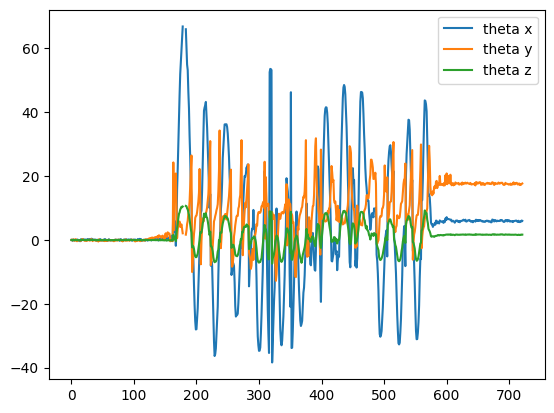

In [75]:
plt.plot(_theta_x_0, label="theta x")
plt.plot(_theta_y_0, label="theta y")
plt.plot(_theta_z_0, label="theta z")
plt.legend()

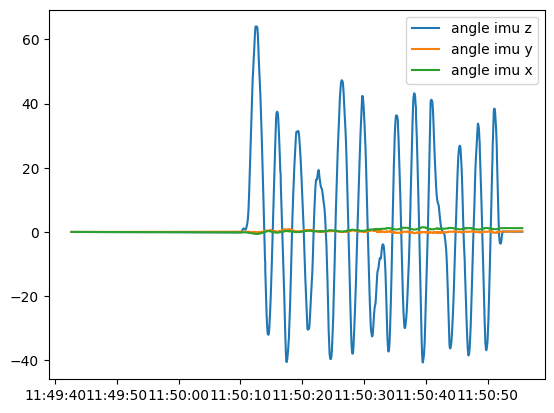

In [76]:
plt.plot(_imu_df["time"],-_imu_df["ang_z"].to_numpy(), label =  "angle imu z")
plt.plot(_imu_df["time"],_imu_df["ang_y"].to_numpy(), label =  "angle imu y")
plt.plot(_imu_df["time"],_imu_df["ang_x"].to_numpy(), label =  "angle imu x")
# plt.plot(_mocap_df["time"], _theta_y, label = "angle mocap z")
plt.legend()

In [77]:
ar_df = pl.DataFrame({"time":ts, "x":coordinate_ml["0"]["x"], "y":coordinate_ml["0"]["y"], "z":coordinate_ml["0"]["z"]})

#convert time to datetime format    
if type(ar_df["time"][0]) != datetime:
    ar_df = ar_df.with_columns(pl.col("time").str.to_datetime())

In [78]:
_imu_df, ar_df = trunkate_dfs(_imu_df.to_pandas(), ar_df.to_pandas())
_imu_df = pl.from_pandas(_imu_df)
ar_df = pl.from_pandas(ar_df)

columns = ["ang_x", "ang_y", "ang_z", "ax", "ay", "az", "gx", "gy", "gz"]

imu_df = pl.from_pandas(interpolate_target_df(_imu_df, ar_df, columns))

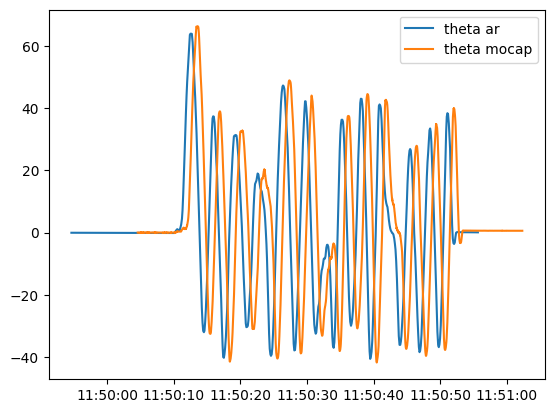

In [79]:
plt.plot(ar_df["time"],-imu_df["ang_z"], label="theta ar")
plt.plot(_mc_df["time"],_theta_y, label="theta mocap")
plt.legend()

In [80]:
_mdf = _mocap_df.copy()
_cdf = ar_df.to_pandas()
_cols = []
for i in ["x", "y", "z"]:
    _cols.append(_om[i])
    _cols.append(_xm[i])
    _cols.append(_zm[i])
_cdf["time"] = pd.to_datetime(_cdf["time"])

In [81]:
_mo_df = interpolate_target_df(_mdf, _cdf, _cols)

In [82]:
_mo_df = pl.from_pandas(_mo_df)

In [83]:
_rinpmat = []
for i in tqdm(range(len(_mo_df))):
    
    _x_vec = _mo_df[[_xm["x"], _xm["y"], _xm["z"]]][i, :].to_numpy().T
    _org = _mo_df[[_om["x"], _om["y"], _om["z"]]][i, :].to_numpy().T
    _z_vec = _mo_df[[_zm["x"], _zm["y"], _zm["z"]]][i, :].to_numpy().T

    _rinpmat.append(calculate_rotmat(_x_vec, _z_vec, _org))

100%|██████████| 612/612 [00:00<00:00, 2571.32it/s]


In [84]:
_imurmat = []
_i_theta = 0
for i in range(len(imu_df)):
    _i_theta = np.deg2rad(imu_df["ang_y"][i])
    _imurmat.append(np.array([[np.cos(_i_theta), 0, np.sin(_i_theta)],
                            [0, 1, 0],
                            [-np.sin(_i_theta), 0, np.cos(_i_theta)]]))

Marker 0

In [85]:
np.rad2deg(np.arctan2(rmat[0][1][0], rmat[0][0][0]))

-91.59275700561561

In [86]:
rA_m1 = np.array([0.02, 0., -0.115]).reshape(3, 1)
rA_m1_d = np.array([0., 0.03, -0.115]).reshape(3, 1)

In [87]:
rm = rmat[0]
i = rm
tx = np.arctan2(i[2,1], i[2,2])
ty = np.arctan2(-i[2,0], np.sqrt(i[2,1]**2 + i[2,2]**2))
tz = np.arctan2(i[1,0], i[0,0])
print(np.rad2deg(tx), np.rad2deg(ty), np.rad2deg(tz))

-175.35871904605153 -14.798260941370929 -91.59275700561561


In [88]:
offset = np.array([0., 0., 0.]).reshape(3,1)

initial = np.array([0., 0., 0.]).reshape(3,1)

newdata = {"x":[], "y":[], "z":[]}
for i in range(len(ar_df)):

    val = ar_df[["x", "y", "z"]][i].to_numpy().reshape(3,1)
    
    pa_c = (rmat[i] @ rA_m1 + val)
    
    pa_b = _ar_lframe_rot.T @ (pa_c - _ar_lframe_org )
    
    val = pa_b

    if i == 0:
        initial = val
    if val is None:
        rval = np.nan
    else:
        rval = val - offset

    reval = (rotMat.T @ (rval - initial)).T[0]
    newdata["x"].append(reval[0])
    newdata["y"].append(reval[1])
    newdata["z"].append(reval[2])

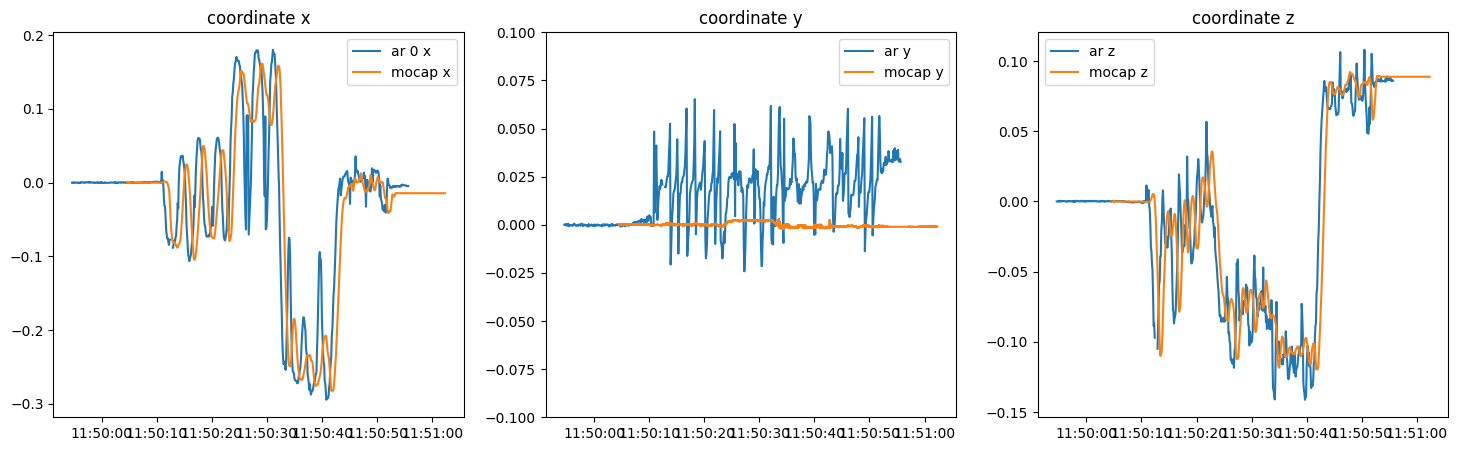

In [89]:

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True,
                                    figsize=(18, 5))

ax0.plot(ar_df["time"],np.array(newdata["x"]), label="ar 0 x")
ax0.plot(_mc_df["time"],_mc_df["x"] - _mc_df["x"][0], label="mocap x")
# ax0.set_ylim(-0.3, 0.3)
ax0.set_title("coordinate x")
ax0.legend()

ax1.plot(ar_df["time"],np.array(newdata["y"]), label="ar y")
ax1.plot(_mc_df["time"],_mc_df["y"] - _mc_df["y"][0], label="mocap y")


ax1.set_ylim(-0.1, 0.1)
ax1.set_title("coordinate y")
ax1.legend()

ax2.plot(ar_df["time"],np.array(newdata["z"]), label="ar z")
ax2.plot(_mc_df["time"],_mc_df["z"] - _mc_df["z"][0], label="mocap z")

ax2.set_title("coordinate z")
# ax2.set_ylim(-0.3, 0.3) 

plt.legend()

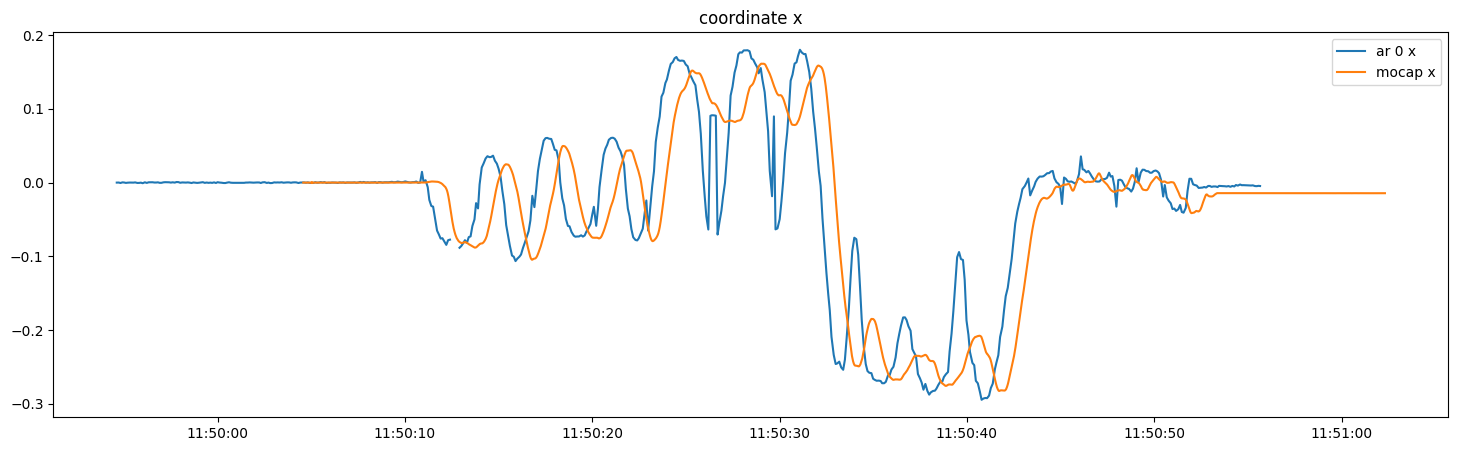

In [90]:
fig, (ax0) = plt.subplots(nrows=1, ncols=1, sharex=True,
                                    figsize=(18, 5))

ax0.plot(ar_df["time"],np.array(newdata["x"]), label="ar 0 x")
ax0.plot(_mc_df["time"],_mc_df["x"] - _mc_df["x"][0], label="mocap x")
# ax0.set_ylim(-0.3, 0.3)
ax0.set_title("coordinate x")
ax0.legend()

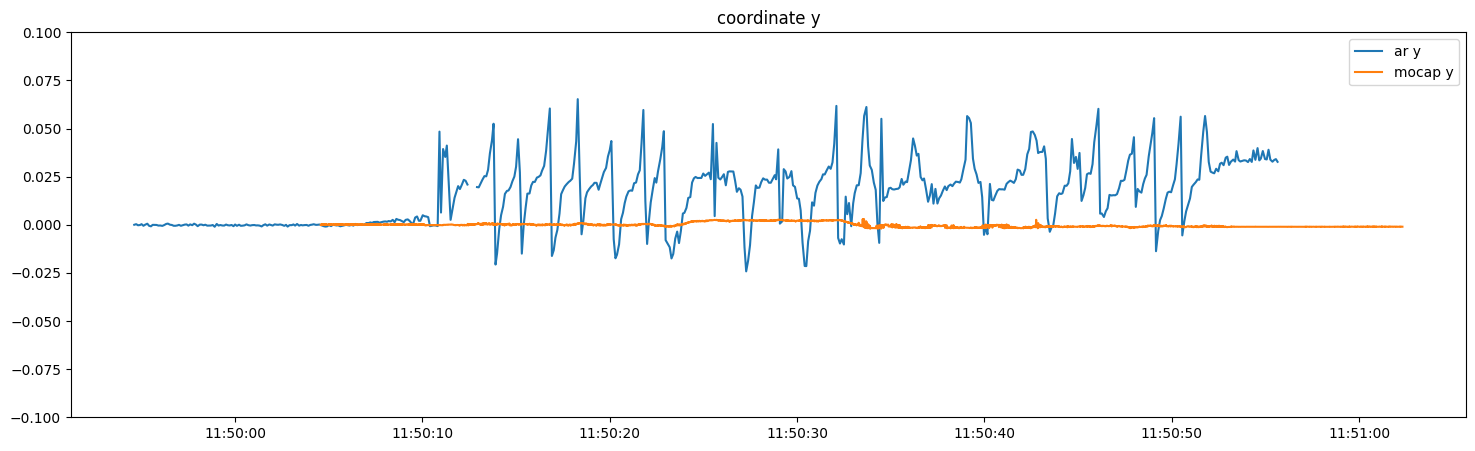

In [91]:
fig, (ax0) = plt.subplots(nrows=1, ncols=1, sharex=True,
                                    figsize=(18, 5))

ax0.plot(ar_df["time"],np.array(newdata["y"]), label="ar y")
ax0.plot(_mc_df["time"],_mc_df["y"] - _mc_df["y"][0], label="mocap y")
ax0.set_ylim(-0.1, 0.1)
ax0.set_title("coordinate y")
ax0.legend()

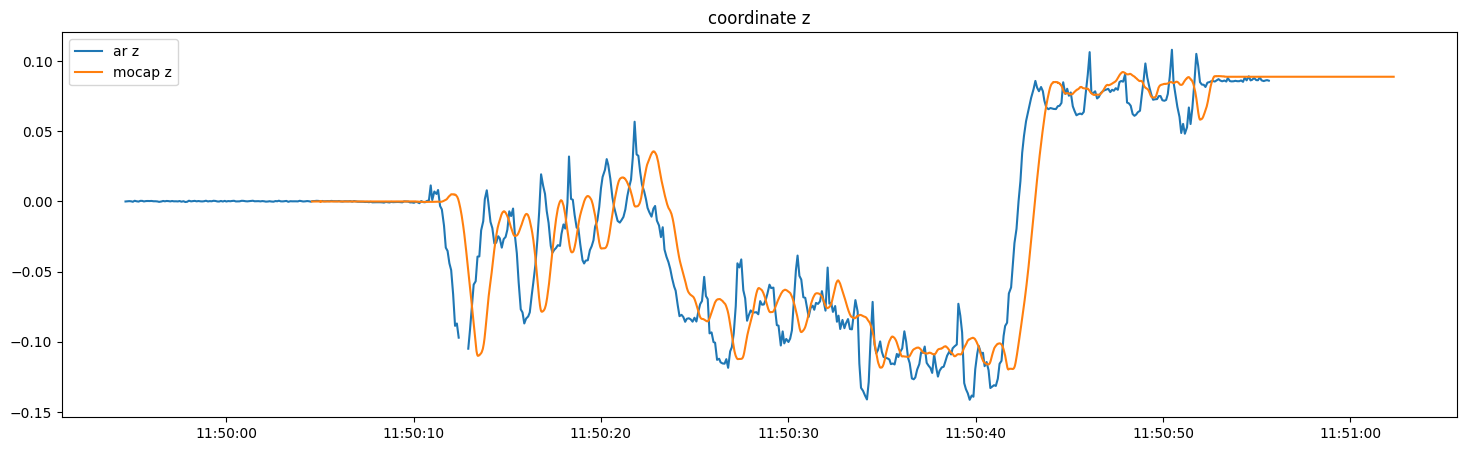

In [92]:
fig, (ax0) = plt.subplots(nrows=1, ncols=1, sharex=True,
                                    figsize=(18, 5))

ax0.plot(ar_df["time"],np.array(newdata["z"]), label="ar z")
ax0.plot(_mc_df["time"],_mc_df["z"] - _mc_df["z"][0], label="mocap z")
ax0.set_title("coordinate z")
ax0.legend()